# Search: Solving a Maze Using a Goal-based Agent
Nicholas Larsen

## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in (i.e., the environment is deterministic, discrete, and known). The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  

This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent can just follow the path and does not need percepts. The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree and the goal is to traverse all nodes. We are interested in dynamically creating a search tree with the aim of finding a good/the best path to the goal state. Follow the pseudo code presented in the text book closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Here is the small example maze:

In [1]:
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore search may not form proper trees unless cycles are prevented. You need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation.

In [2]:
%run maze_helper.py

maze = parse_maze(maze_str)

# look at two positions in the maze
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)`
print("Position(8,1):", look(maze, (8, 1)))
print(maze_str)
print(len(maze), len(maze[0]))

Position(0,0): X
Position(8,1): G
XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX

10 22


Visualize the maze

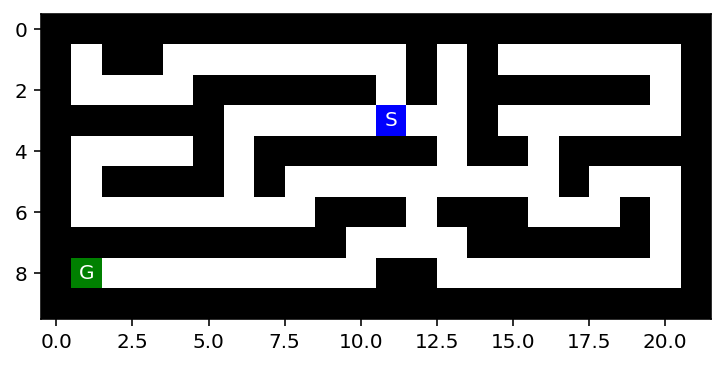

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


## Tree structure

Implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73):

In [5]:
class Node:
    def __init__(self, pos, parent, action, cost, depth = 0):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.frontier = []
        self.depth = depth

    def __lt__(self, o):
        return self.cost < o.cost
    
    def __str__(self):
        return f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}; depth = {self.depth}"

Example: Create the root node and append the node for going east with a cost of 1.

In [6]:
print("Create root node")
root = Node(pos = (0,0), parent = None, action = None, cost = 0)
print("root:", root)
print("root (reference):", repr(root))

print()
print("Go east with cost 1 (from the parent root)")
node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1)
print("node2:", node2)
print("parent of node2: ", node2.parent)
print("parent of node2 (reference): ", repr(node2.parent))

print()
print("Note that the root note is safe from garbage collection as long as we have a reference in node2") 
root = None
print(root)
print("parent of node2 (reference): ", repr(node2.parent))

print()
print("Once we release node2, the whole tree is deleted.")
node2 = None

Create root node
root: Node - pos = (0, 0); parent = None; action = None; cost = 0; depth = 0
root (reference): <__main__.Node object at 0x0000012FF257B748>

Go east with cost 1 (from the parent root)
node2: Node - pos = (0, 1); parent = <__main__.Node object at 0x0000012FF257B748>; action = E; cost = 1; depth = 0
parent of node2:  Node - pos = (0, 0); parent = None; action = None; cost = 0; depth = 0
parent of node2 (reference):  <__main__.Node object at 0x0000012FF257B748>

Note that the root note is safe from garbage collection as long as we have a reference in node2
None
parent of node2 (reference):  <__main__.Node object at 0x0000012FF257B748>

Once we release node2, the whole tree is deleted.


# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Iterative deepening search (IDS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth searched
* Maximum size of the frontier.

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search Problem [1 point]

Define the components of the search problem:

* **Initial state**: the square in the maze that contains an S
* **Actions**: 
 * West: col - 1
 * East: col + 1
 * Norht: row - 1
 * South: row + 1
* **Transition model**: Perform the operation corresponding to the action aboce
* **Goal state**: The square with S in it
* **Path cost**: Each square costs 1 to move to

## Task 2: Breadth-first and Depth-first [4 points]

Implement these search strategies. Note that the algorithms for BFS and DFS are very different! Make sure that DFS uses less memory by releasing nodes that are not needed anymore. 

### Breadth-Frist-Search

In [7]:
# Your code goes here
# Expand will return a list of nodes that we can go to from the current node
#class Node:
#    def __init__(self, pos, parent, action, cost):

from collections import deque

def expand(node, maze):
    options = []
    h = len(maze)
    w = len(maze[1])
    can_go_north = node.pos[0] - 1 >= 0 and maze[node.pos[0] - 1, node.pos[1]] != 'X'
    can_go_south = node.pos[0] + 1 < h and maze[node.pos[0] + 1, node.pos[1]] != 'X'
    can_go_east = node.pos[1] + 1 < w and maze[node.pos[0], node.pos[1]+1] != 'X'
    can_go_west = node.pos[1] -1 >= 0 and maze[node.pos[0], node.pos[1]-1] != 'X'
    if can_go_north:
        new_node = Node((node.pos[0] - 1, node.pos[1]), node, 'N', node.cost+1, depth=node.depth+1)
        options.append(new_node)
    if can_go_south:
        new_node = Node((node.pos[0] + 1, node.pos[1]), node, 'S', node.cost+1, depth=node.depth+1)
        options.append(new_node)
    if can_go_east:
        new_node = Node((node.pos[0], node.pos[1] + 1), node, 'E', node.cost+1, depth=node.depth+1)
        options.append(new_node)
    if can_go_west:
        new_node = Node((node.pos[0], node.pos[1] - 1), node, 'W', node.cost+1, depth=node.depth+1)
        options.append(new_node)
    
    return options


def set_to_dot(maze, pos, dot = '.'):
    maze_pos = maze[pos[0]][pos[1]]
    if maze_pos != 'G' and maze_pos != 'S' and maze_pos != 'X':
        maze[pos[0]][pos[1]] = dot

def get_path(node, maze, dot = 'P'):
    if node.parent is None:
        return ''
    if maze[node.pos[0]][node.pos[1]] != 'S' and maze[node.pos[0]][node.pos[1]] != 'G':
        set_to_dot(maze, node.pos, dot = dot)
    return get_path(node.parent, maze, dot=dot) + node.action
    
    
def breadth_first_search(maze, node, verbose = False):
    # stats for performance mesure
    nodes_expanded = 1
    max_tree_depth = 1
    max_tree_size = 1
    max_frontier_size = 1
    tree_size = 1
    
    if maze[node.pos[0], node.pos[1]] == 'G':
        return node
    frontier = deque() # LIFO or FIFO depending on Breadth or Depth
    frontier.append(node)
    reached = {} # set of visited nodes. For efficency this needs to be a hash set
    while not len(frontier) == 0:
        next_node = frontier.popleft()
        tree_size-=1
        if maze[next_node.pos[0]][next_node.pos[1]] == 'G':
            get_path(next_node, maze)
            return (next_node,
                    nodes_expanded,
                    max_tree_depth,
                    max_tree_size,
                    max_frontier_size)
        
        if maze[next_node.pos[0]][next_node.pos[1]] != 'S':
            maze[next_node.pos[0]][next_node.pos[1]] = '.'
        nodes_expanded += 1
        childs = expand(next_node, maze)
        had_child = False
        for child in childs:
            if child.pos not in reached or child.cost < reached[child.pos].cost:
                had_child = True
                reached[child.pos] = child
                set_to_dot(maze, child.pos, dot='F')
                frontier.append(child)
                tree_size+=1
                
        max_frontier_size = max(len(frontier), max_frontier_size)
        max_tree_depth = max(next_node.depth, max_tree_depth)
        max_tree_size = max(tree_size, max_tree_size)
        
        if not had_child:
            next_node = None
        if verbose:
            show_maze(maze)
    return None
    


Wall time: 2 ms
breadth first search path EESSWSSWWSWWWWWWWWW
Nodes Expanded: 94,  Max Tree Depth: 19,  Max Tree Size: 9,  Max Frontier Size: 9


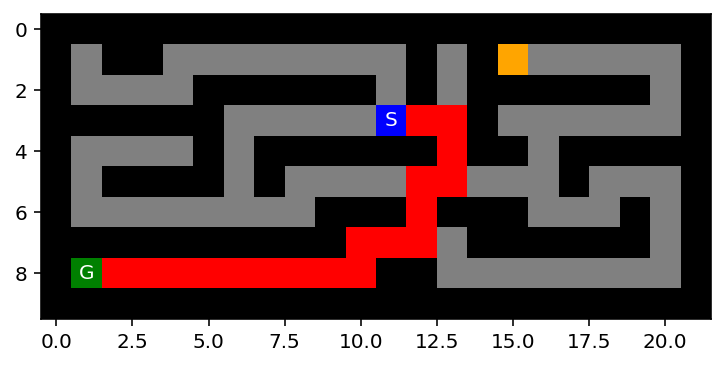

Wall time: 3.97 ms
breadth first search path WWWWWWWWWSSEESSSWWWNWWWWSSSEEEEEEESSSSSSSWWWWWWWWWWWWWWWWWSWWWWWWWWW
Nodes Expanded: 271,  Max Tree Depth: 68,  Max Tree Size: 8,  Max Frontier Size: 8


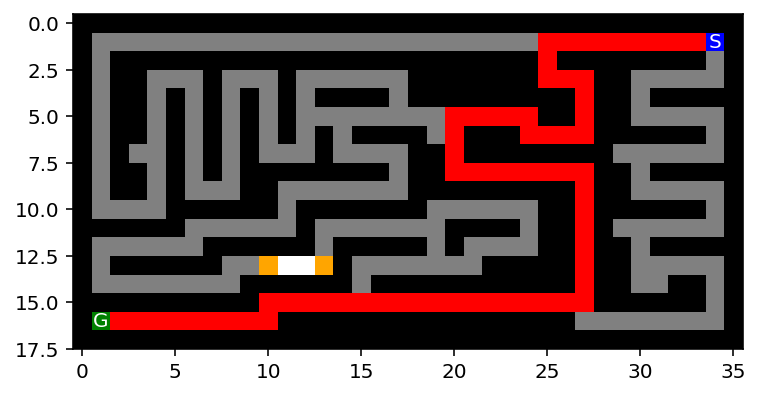

Wall time: 8 ms
breadth first search path NNWWWWNNWWSSWWWWWWWWWWWWWWNNEENNWWNNNNNNEEEEEESSEENNEEEENNEESSEENNNNNNEEEENNNNNNNNNNWWSSWWWWSSSSSSWWSSSSWWNNWWWWWWWWWWWWNNEENNNNNNEEEEEENNNNNNNNWWWWWWSSWWWWSSSSEESSWWWWWWWWWWSSSSSSSSSSEESSSSWWSSSSEESSWWSSSSWWSS
Nodes Expanded: 622,  Max Tree Depth: 210,  Max Tree Size: 8,  Max Frontier Size: 8


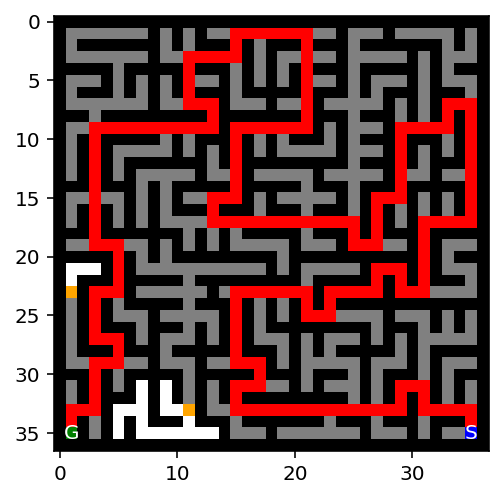

Wall time: 999 µs
breadth first search path NNNNNNNEEEEEEE
Nodes Expanded: 97,  Max Tree Depth: 14,  Max Tree Size: 12,  Max Frontier Size: 12


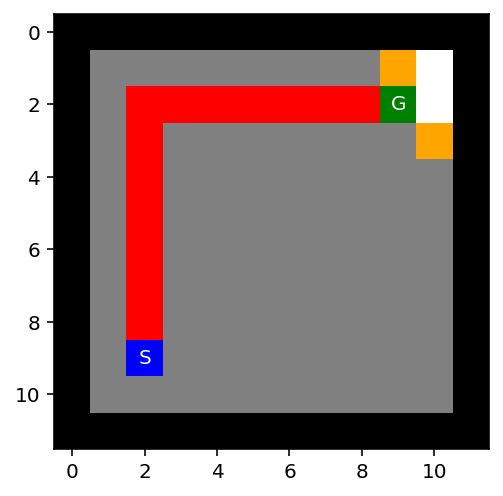

Wall time: 10 ms
breadth first search path SSSSSWWWWWWWWWWWWWWWWSSSSSSSSSSSSSSSWWWWWWWWWWWWWWWWWW
Nodes Expanded: 684,  Max Tree Depth: 53,  Max Tree Size: 25,  Max Frontier Size: 25


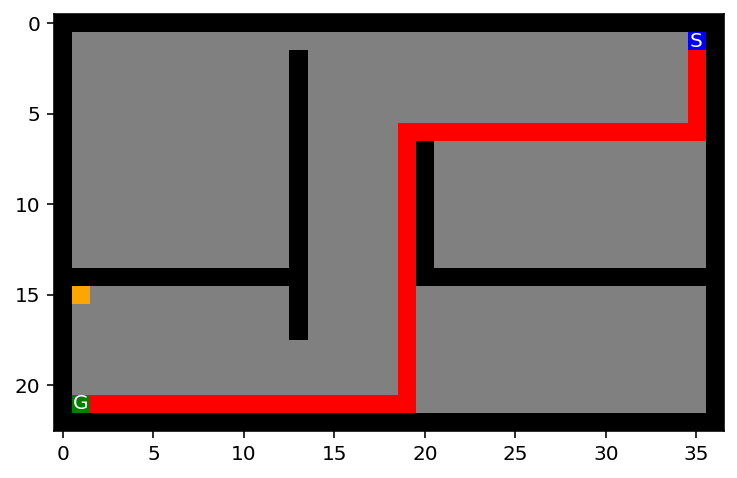

Wall time: 998 µs
breadth first search path EEEEEEENNNNNNNNNWWWWWWW
Nodes Expanded: 73,  Max Tree Depth: 22,  Max Tree Size: 8,  Max Frontier Size: 8


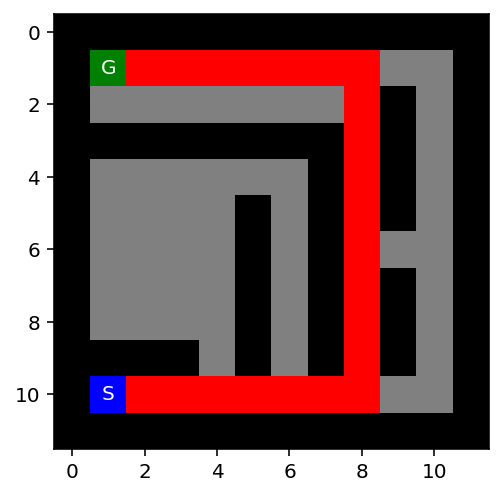

In [8]:
# Run fit on some mazes to test

runs =[]
mazes = [
         "small_maze.txt",
         "medium_maze.txt",
         "large_maze.txt",
         "empty_maze.txt",
         "open_maze.txt",
         "loops_maze.txt"
        ]
for i in range(10):
    for m in mazes:
        f = open(m, "r")
        maze_str = f.read()

        maze = parse_maze(maze_str)

        find_pos(maze, what= 'S')
        initial_node = Node(find_pos(maze, what= 'S'), None, None, 0)
        output = None
        if i == 0:
            %time output = breadth_first_search(maze, initial_node, verbose=False)
        else:
            output = breadth_first_search(maze, initial_node, verbose=False)
        node = output[0]
        path = get_path(node, maze)
        if i == 0:
            print('breadth first search path', path)
            print(f'Nodes Expanded: {output[1]}, ',
                  f'Max Tree Depth: {output[2]}, ',
                  f'Max Tree Size: {output[3]}, ',
                  f'Max Frontier Size: {output[4]}')
        run = []
        run.append(m)
        run.append('breadth-first-search')
        path = get_path(node, maze)
        run.append(len(path))
        run.append(output[1])
        run.append(output[2])
        run.append(output[3])
        run.append(output[4])
        runs.append(run)

        if i == 0: show_maze(maze)

### Depth First Search
#### Algorithm Description
My imlementation will store a frontier in each of the nodes of the tree. Once a path has exhausted all of its options it will clear that node, and step up the tree clearing all parents that also have empty frontiers. Once it finds a node with a node in the frontier it will explore all paths originating from that node. 

There is a catch that had to be implemented to solve mazes that are very open. If the path either steps into a room with a small opening or creates a room on its own with its path, it will take a very long time to step every path in that room, and may never finish in any amount of reasonable time. To prevent this the will only iterate $l\times w$ times, if it reaches this maximum we will assume that it has gotten stuck in one of these types of rooms. Then we will restart and randomly do the algortim again.

Disclaimer: During the algorithm for debuggin purposes it will color the squares of the path, and the square that are in the frontier. When the path hits a exhausted path, it will back track that path until it finds a frontier. During this back track it will color the squares grey just for visulization, but the algorithm will still step over those squares. It is only used for visulization at the end, it is NOT considered reached in any way.

In [9]:
import random

#Helper functions for performing BFS

def get_random_dir_order():
    """Get a random order of tuple:
        (Vector to add to pos, Action)"""
    north = ((-1, 0), 'N')
    south = ((1, 0), 'S')
    east = ((0, 1), 'E')
    west = ((0, -1), 'W')
    l = [north, south, east, west]
    random.shuffle(l)
    return l
        
def step_in_dir(pos, direction):
    """Perform the set in the vector direction"""
    return (pos[0]+direction[0], pos[1]+direction[1])

def expand_in_order(node, maze, order):
    """Expand all of the childern from node in the order of order"""
    options = []
    for direction in order:
        new_pos = step_in_dir(node.pos, direction[0])
        if maze[new_pos[0]][new_pos[1]]!= 'X':
            new_node = Node((new_pos), node, direction[1], node.cost+1, node.depth+1)
            options.append(new_node)
    return options
    

def expand_random(node, maze):
    """use expand_in_order and get_random_dir_order to expand children randomly"""
    order = get_random_dir_order()
    
    options = []
    return expand_in_order(node, maze, order)
            
def is_cycle_help(node, parent):
    """Check if node is the same pos as parent and recur for parents parent"""
    if parent is None:
        return False
    # check it this node is the same position
    if node.pos == parent.pos:
        return True
    # check if this node's position is in any node in the frontier of parent
    for front in parent.frontier:
        if node.pos == front.pos:
            return True
        
    return is_cycle_help(node, parent.parent)

def is_cycle(node):
    """Check if node causes a cycle in its parents"""
    return is_cycle_help(node, node.parent)
    

def reset_maze(maze):
    """Reset all of the maze"""
    for row in range(0, len(maze)):
        for col in range(0, len(maze[row])):
            set_to_dot(maze, (row, col), dot=' ')
                         
def reset_maze_clear_tree(node, maze):
    """Reset Maze and clear search tree"""
    reset_maze(maze)
    get_path(node, maze, ' ')
    while node.parent is not None:
        next_node = node.parent
        node = None
        node = next_node

def print_parent_structure(node):
    """Print the parent structre for debugging"""
    if node is not None:
        return f'({node.pos})>{print_parent_structure(node.parent)}'

def print_frontier(frontier):
    """Print fontier for debugging"""
    st = ''
    if len(frontier) == 0:
        return
    node = frontier.pop()
    print(node.pos, '<', end='')
    print_frontier(frontier)
    frontier.append(node)

# define the orders:
NESW = [((-1, 0), 'N'), ((0, 1), 'E'), ((1, 0), 'S'), ((0, -1), 'W')]

In [10]:
def depth_first_search(maze,
                       node,
                       verbose_graph=False,
                       verbose_text=False):
    
    # if the amount of steps gets to l*w*5 restart
    max_steps = maze.shape[0]*maze.shape[1]
    
    # stats to keep and return
    search_runs = 0
    nodes_expanded = 0
    max_tree_depth = 1
    max_tree_size = 0 # tree depth + frontier size
    max_frontier_size = 0
    while True:
        search_runs += 1
        steps = 0
        curr_node = node

        frontier_size = 0
        tree_size = 0

        while curr_node is not None:
            if verbose_text:
                print('Steps: ', steps)
                
            if steps >= max_steps:
                if verbose_text:
                    print('Restarting, possible stuck')
                reset_maze_clear_tree(curr_node, maze)
                break
                
                
            get_path(curr_node, maze)

            children = expand_random(curr_node, maze)
            max_tree_depth = max(curr_node.depth, max_tree_depth)
            nodes_expanded += 1
            max_tree_size = max(max_tree_size, curr_node.depth + frontier_size)
            for child in children:
                if not is_cycle(child):
                    if verbose_text:
                        print('adding', child.pos, 'to', curr_node.pos)
                    set_to_dot(maze, child.pos, dot='F')
                    frontier_size += 1
                    max_frontier_size = max(max_frontier_size, frontier_size)
                    curr_node.frontier.append(child)

            if verbose_graph:
                show_maze(maze)

            # free up the nodes with no frontier
            if len(curr_node.frontier) == 0:
                while len(curr_node.frontier) == 0:
                    if verbose_text:
                        print('Removing', curr_node)
                    set_to_dot(maze, curr_node.pos, dot='.')
                    next_node = curr_node.parent
                    curr_node == None
                    curr_node = next_node

            get_path(curr_node, maze, '.')
            frontier_size -= 1
            curr_node = curr_node.frontier.pop()

            if maze[curr_node.pos[0]][curr_node.pos[1]] == 'G':
                get_path(curr_node, maze)
                return (curr_node,search_runs,nodes_expanded,max_tree_depth,max_tree_size,max_frontier_size)
            steps+=1
        
        
    return (node,search_runs,nodes_expanded,max_tree_depth,max_tree_size,max_frontier_size)

Wall time: 6 ms
Runs:1 Nodes Expaned: 49 Max Tree Depth 48 Max Tree Size 54 Max Frontier Size 7


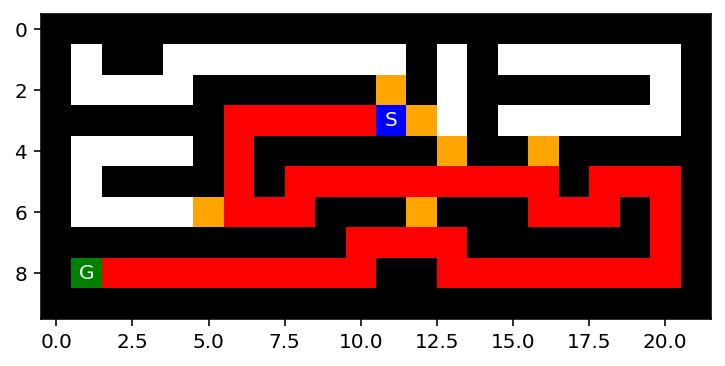

Wall time: 79 ms
Runs:1 Nodes Expaned: 182 Max Tree Depth 148 Max Tree Size 156 Max Frontier Size 9


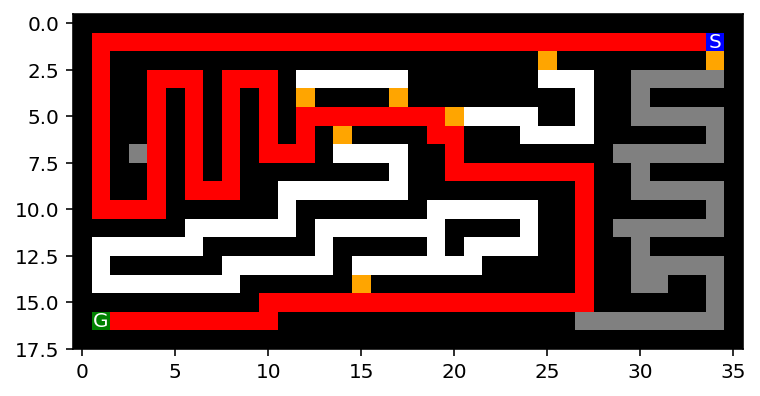

Wall time: 197 ms
Runs:1 Nodes Expaned: 369 Max Tree Depth 214 Max Tree Size 252 Max Frontier Size 39


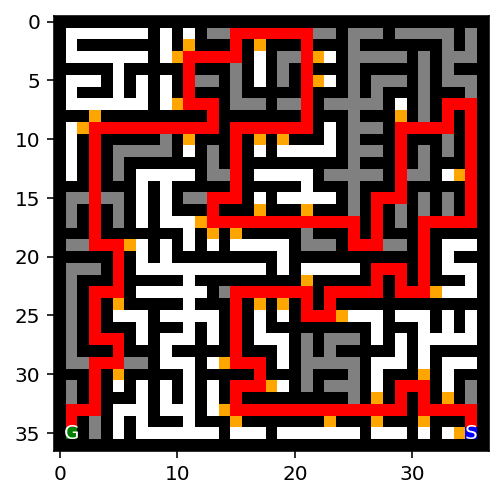

Wall time: 11.5 ms
Runs:1 Nodes Expaned: 69 Max Tree Depth 44 Max Tree Size 86 Max Frontier Size 45


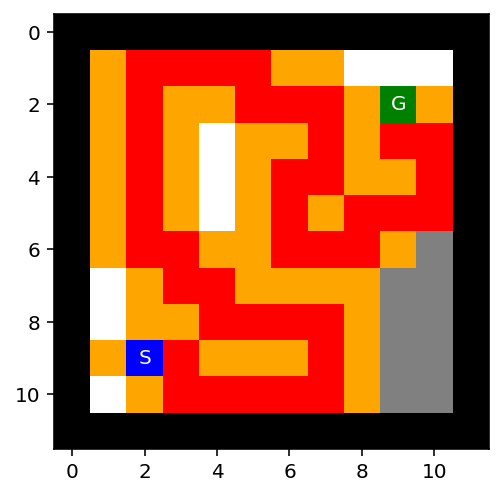

Wall time: 134 ms
Runs:1 Nodes Expaned: 341 Max Tree Depth 93 Max Tree Size 185 Max Frontier Size 94


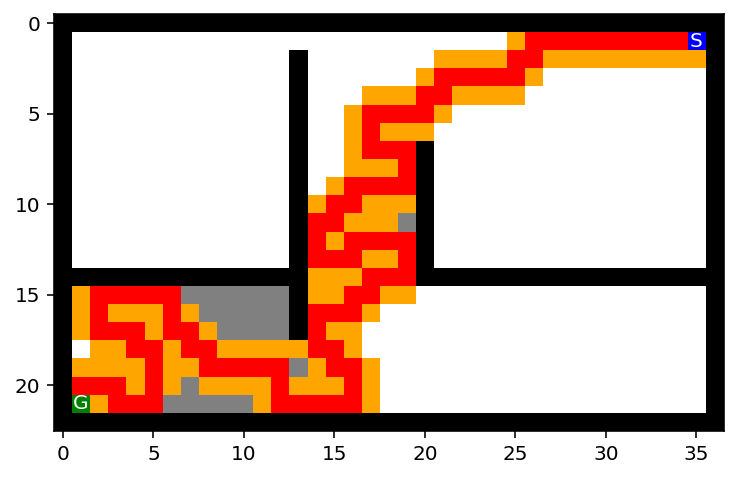

Wall time: 8 ms
Runs:1 Nodes Expaned: 66 Max Tree Depth 45 Max Tree Size 55 Max Frontier Size 13


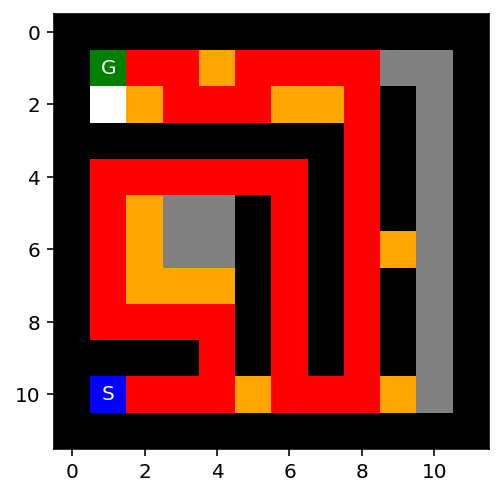

In [11]:
# Run fit on some mazes to test
mazes = [
        "small_maze.txt",
        "medium_maze.txt",
        "large_maze.txt",
        "empty_maze.txt",
        "open_maze.txt",
        "loops_maze.txt"
        ]

for i in range(10):
    for m in mazes:
        f = open(m, "r")
        maze_str = f.read()

        maze = parse_maze(maze_str)

        find_pos(maze, what= 'S')
        #print("Start location:", find_pos(maze, what = "S"))
        initial_node = Node(find_pos(maze, what= 'S'), None, None, 0)
        output = None
        if i == 0:
            %time output = depth_first_search(maze, initial_node, verbose_text=False, verbose_graph=False)
        else:
            output = depth_first_search(maze, initial_node, verbose_text=False, verbose_graph=False)
        #node,search_runs,nodes_expanded,max_tree_depth,max_tree_size,max_frontier_size
        if i == 0:
            print(f"Runs:{output[1]} Nodes Expaned: {output[2]} Max Tree Depth {output[3]} Max Tree Size {output[4]}",
                 f"Max Frontier Size {output[5]}")
        if i == 0: show_maze(maze)

        run = []
        run.append(m)
        run.append('depth-first-search')
        path = get_path(output[0], maze)
        run.append(len(path))
        run.append(output[2])
        run.append(output[3])
        run.append(output[4])
        run.append(output[5])
        runs.append(run)


**How do you deal with loops (cycles)?**

Do deal with cycles, every time a node is being added to the tree the algorithm will step up its parent structure and check if that position exists in either the node, or that nodes frontier, if it does it will be considered a cycle and will not be added to the fontier.


**Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?**

Breadth-First-Search
* Complete: If there is a solution this implementation of Breadth-Frist-Search will find it.
* Optimal: Since the algorithm will go level by level, it garentees that it will find the path that costs the least

Depth-First-Search
* Complete: If there is a solution this implentation of Depth-First-Search will find it. 
* Optimal: Since it will expand each path until failure, it will return the first solution it finds, and the example above even shows an example that does not return the optimal solution


## Task 3: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function.

In [12]:
from queue import PriorityQueue

def print_p_queue(frontier):
    if frontier.empty():
        return
    
    tup = frontier.get()
    print(tup[1].pos, tup[0], '; ', end='')
    print_p_queue(frontier)
    frontier.put(tup)

def manhattan_dist(maze, pos, goal_pos):
    return abs(pos[0] - goal_pos[0]) + abs(pos[1] - goal_pos[1])
    
    
def best_first_search(maze,
                      node,
                      a_star_mode=False,
                      verbose_graph=False,
                      verbose_text=False):
    
    goal_pos = find_pos(maze, 'G')
    next_node = node
    frontier = PriorityQueue()
    weight = manhattan_dist(maze, node.pos, goal_pos)
    frontier.put((weight, initial_node))
    reached = {}
    
    nodes_expanded = 0
    max_tree_depth = 1
    max_tree_size = 1
    max_frontier_size = 0
    
    while not frontier.empty():
        tup = frontier.get() # get the node of the next thing on the frontier
        next_node = tup[1]
        get_path(next_node, maze, dot='P') 
        
        if look(maze, next_node.pos) == 'G':
            return (next_node,
                    nodes_expanded,
                    max_tree_depth,
                    max_tree_size,
                    max_frontier_size)
        
        if verbose_text:
            print('expanding', next_node)
            
        nodes_expanded += 1
        children = expand_random(next_node, maze)
        for child in children:
            if child.pos not in reached or child.cost < reached[child.pos].cost:
                reached[child.pos] = child
                weight = manhattan_dist(maze, child.pos, goal_pos)
                if a_star_mode:
                    weight += child.cost
                set_to_dot(maze, child.pos, dot = 'F')
                frontier.put((weight, child))
                max_tree_depth = max(child.depth, max_tree_depth)
        max_tree_size = max(len(reached), max_tree_size)
        max_frontier_size = max(frontier.qsize(), max_frontier_size)
        
                
       
        if verbose_text:
            print_p_queue(frontier)
                
        if verbose_graph:
            show_maze(maze)
        get_path(next_node, maze, dot='.')         
    return None


        

### Greedy Best First Performance

Wall time: 3.03 ms
 Nodes Expaned: 39 Max Tree Depth 29 Max Tree Size 44 Max Frontier Size 6


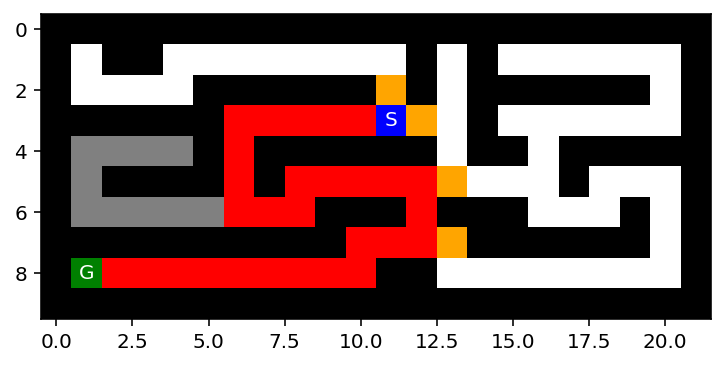

Wall time: 14 ms
 Nodes Expaned: 78 Max Tree Depth 74 Max Tree Size 82 Max Frontier Size 5


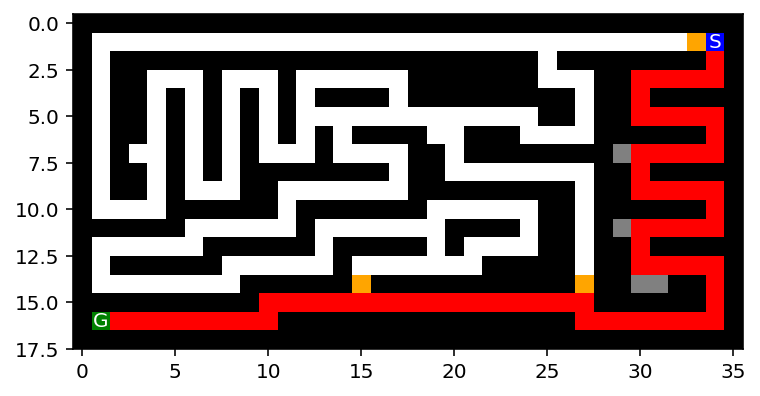

Wall time: 202 ms
 Nodes Expaned: 470 Max Tree Depth 210 Max Tree Size 489 Max Frontier Size 20


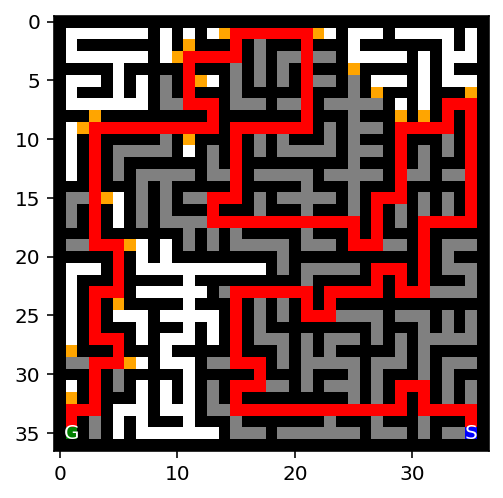

Wall time: 1.75 ms
 Nodes Expaned: 14 Max Tree Depth 14 Max Tree Size 36 Max Frontier Size 23


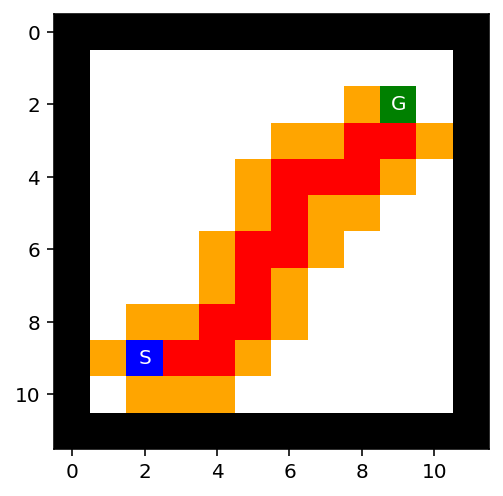

Wall time: 15.9 ms
 Nodes Expaned: 89 Max Tree Depth 68 Max Tree Size 170 Max Frontier Size 82


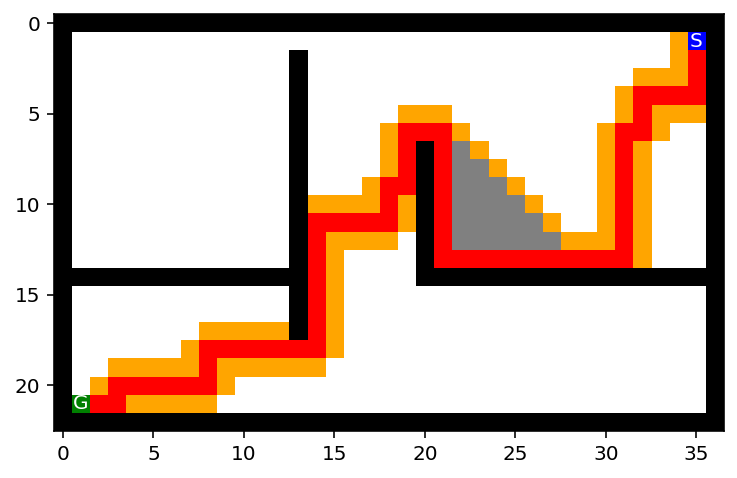

Wall time: 5 ms
 Nodes Expaned: 73 Max Tree Depth 23 Max Tree Size 60 Max Frontier Size 10


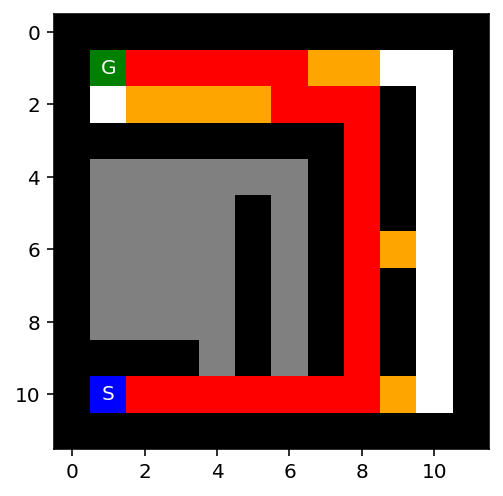

In [13]:
# Run fit on some mazes to test
mazes = [
        "small_maze.txt",
        "medium_maze.txt",
        "large_maze.txt",
        "empty_maze.txt",
        "open_maze.txt",
        "loops_maze.txt"
        ]

for i in range(10):
    for m in mazes:
        f = open(m, "r")
        maze_str = f.read()

        maze = parse_maze(maze_str)

        find_pos(maze, what= 'S')
        #print("Start location:", find_pos(maze, what = "S"))
        initial_node = Node(find_pos(maze, what= 'S'), None, None, 0)
        output = None
        if i == 0:
            %time output = best_first_search(maze, initial_node, a_star_mode=False, verbose_text=False, verbose_graph=False)
        else:
            output = best_first_search(maze, initial_node, a_star_mode=False, verbose_text=False, verbose_graph=False)
        #node,search_runs,nodes_expanded,max_tree_depth,max_tree_size,max_frontier_size
        if i == 0:
            print(f" Nodes Expaned: {output[1]} Max Tree Depth {output[2]} Max Tree Size {output[3]}",
                 f"Max Frontier Size {output[4]}")
        
        if i==0: show_maze(maze)

        run = []
        run.append(m)
        run.append('greedy-best-first-search')
        path = get_path(output[0], maze)
        run.append(len(path))
        run.append(output[1])
        run.append(output[2])
        run.append(output[3])
        run.append(output[4])
        runs.append(run)

### A* Performance

Wall time: 4.99 ms
 Nodes Expaned: 54 Max Tree Depth 19 Max Tree Size 59 Max Frontier Size 8


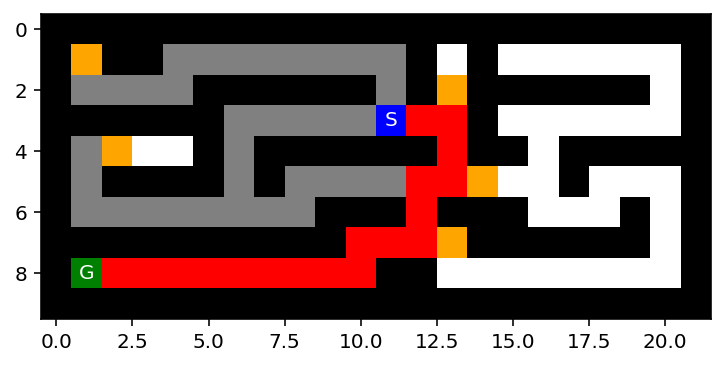

Wall time: 58 ms
 Nodes Expaned: 222 Max Tree Depth 68 Max Tree Size 228 Max Frontier Size 8


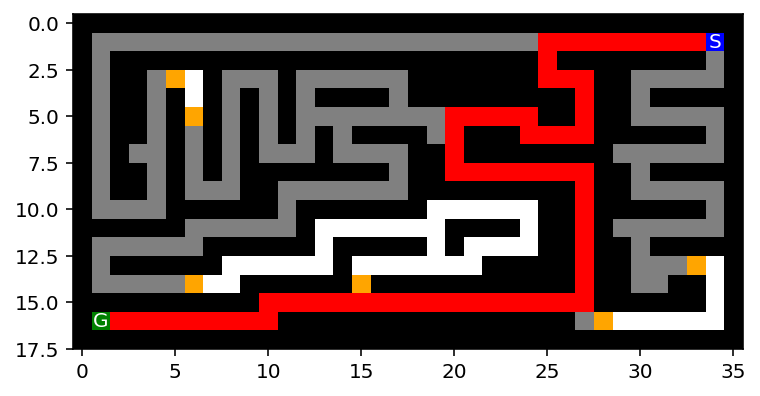

Wall time: 273 ms
 Nodes Expaned: 550 Max Tree Depth 210 Max Tree Size 557 Max Frontier Size 12


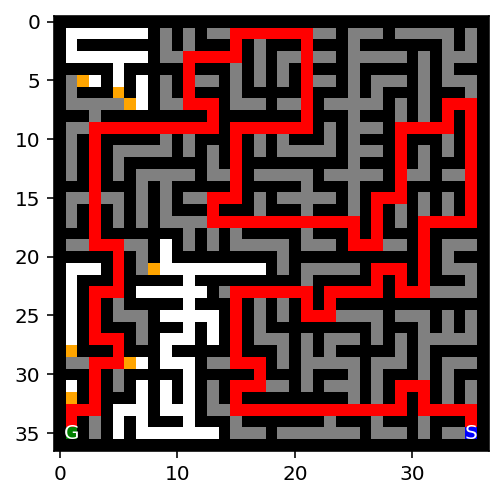

Wall time: 4.02 ms
 Nodes Expaned: 63 Max Tree Depth 14 Max Tree Size 94 Max Frontier Size 32


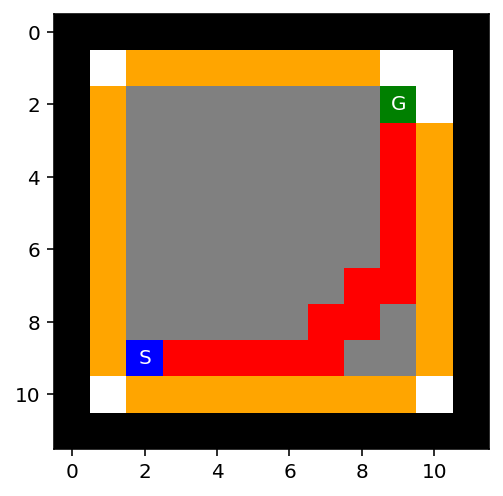

Wall time: 81 ms
 Nodes Expaned: 535 Max Tree Depth 54 Max Tree Size 555 Max Frontier Size 28


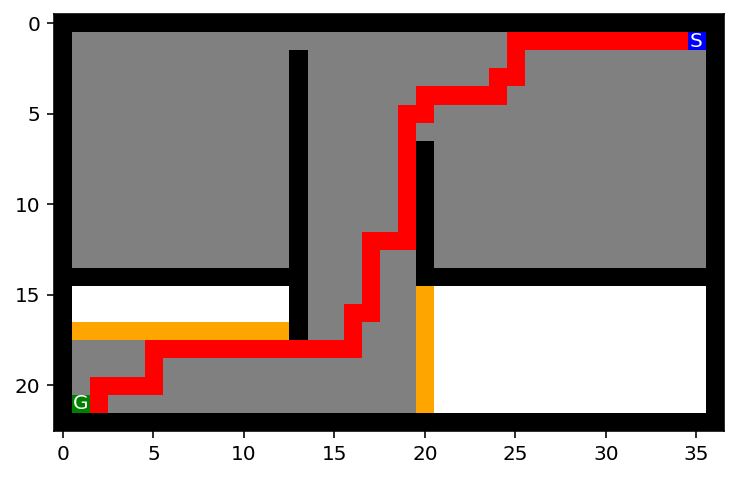

Wall time: 5 ms
 Nodes Expaned: 59 Max Tree Depth 23 Max Tree Size 62 Max Frontier Size 6


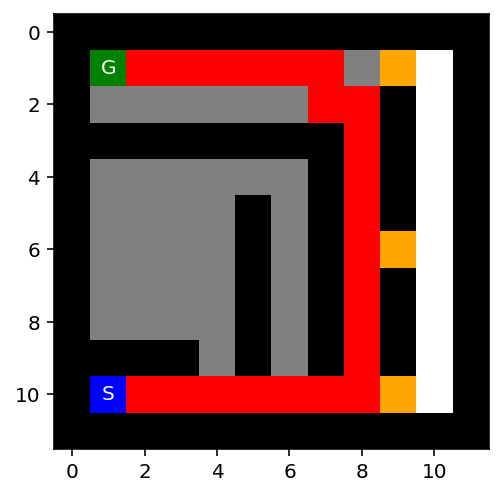

In [14]:
# Run fit on some mazes to test
mazes = [
        "small_maze.txt",
        "medium_maze.txt",
        "large_maze.txt",
        "empty_maze.txt",
        "open_maze.txt",
        "loops_maze.txt"
        ]

for i in range(1):
    for m in mazes:
        f = open(m, "r")
        maze_str = f.read()

        maze = parse_maze(maze_str)

        find_pos(maze, what= 'S')
        #print("Start location:", find_pos(maze, what = "S"))
        initial_node = Node(find_pos(maze, what= 'S'), None, None, 0)
        output = None
        if i == 0:
            %time output = best_first_search(maze, initial_node, a_star_mode=True, verbose_text=False, verbose_graph=False)
        else:
            output = best_first_search(maze, initial_node, a_star_mode=True, verbose_text=False, verbose_graph=False)
        #node,search_runs,nodes_expanded,max_tree_depth,max_tree_size,max_frontier_size
        if i == 0:
            print(f" Nodes Expaned: {output[1]} Max Tree Depth {output[2]} Max Tree Size {output[3]}",
                 f"Max Frontier Size {output[4]}")

        run = []
        run.append(m)
        run.append('a-star-search')
        path = get_path(output[0], maze)
        run.append(len(path))
        run.append(output[1])
        run.append(output[2])
        run.append(output[3])
        run.append(output[4])
        runs.append(run)
        if i == 0: show_maze(maze)

Are your implementations complete and optimal? What is the time and space complexity?

#### Greedy Best First
* GBFS is complete, it will find the solution if it exists
* GBFS is not optimal, as you can see in the open_maze it does not find the most optimal path
* Time Complexity:
* Space Complexity:

#### A-Star Search
* A-Star is complete, it will find the solution if it exists
* A-Star is optimal IF the heuristic is admissible, in this case it is
* Time Complexity:
* Space Complexity:

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts.

In [15]:
import pandas as pd
df = pd.DataFrame(runs, columns = ['maze',
                                   'search_strat',
                                   'path_cost',
                                   'nodes_expanded',
                                   'max_tree_depth',
                                   'max_tree_size',
                                   'max_frontier_size'])

### Broad overview of data

In [16]:
df_grouped_means = df.groupby(['maze', 'search_strat']).mean()
display(df_grouped_means)

path_cost  nodes_expanded  \
maze            search_strat                                          
empty_maze.txt  a-star-search                  14.0            63.0   
                breadth-first-search           14.0            97.0   
                depth-first-search             30.0           258.5   
                greedy-best-first-search       14.0            14.0   
large_maze.txt  a-star-search                 210.0           550.0   
                breadth-first-search          210.0           622.0   
                depth-first-search            210.0           415.4   
                greedy-best-first-search      210.0           462.6   
loops_maze.txt  a-star-search                  23.0            59.0   
                breadth-first-search           23.0            73.0   
                depth-first-search             36.4           147.9   
                greedy-best-first-search       23.0            71.9   
medium_maze.txt a-star-search                  68.0           222.0   
                breadth-first-search           68.0           271.0   
                depth-first-search            147.4           249.1   
                greedy-best-first-search       89.6            94.0   
open_maze.txt   a-star-search                  54.0           535.0   
                breadth-first-search           54.0           684.0   
                depth-first-search            113.4          8012.4   
                greedy-best-first-search       62.2           104.4   
small_maze.txt  a-star-search                  19.0            54.0   
                breadth-first-search           19.0            94.0   
                depth-first-search             37.4            53.7   
                greedy-best-first-search       29.0            39.0   

                                          max_tree_depth  max_tree_size  \
maze            search_strat                                              
empty_maze.txt  a-star-search                       14.0           94.0   
                breadth-first-search                14.0           12.0   
                depth-first-search                  36.7           69.2   
                greedy-best-first-search            14.0           37.8   
large_maze.txt  a-star-search                      210.0          557.0   
                breadth-first-search               210.0            8.0   
                depth-first-search                 216.7          252.2   
                greedy-best-first-search           210.0          483.7   
loops_maze.txt  a-star-search                       23.0           62.0   
                breadth-first-search                22.0            8.0   
                depth-first-search                  36.1           47.0   
                greedy-best-first-search            23.0           60.5   
medium_maze.txt a-star-search                       68.0          228.0   
                breadth-first-search                68.0            8.0   
                depth-first-search                 173.7          182.0   
                greedy-best-first-search            89.6           98.8   
open_maze.txt   a-star-search                       54.0          555.0   
                breadth-first-search                53.0           25.0   
                depth-first-search                 153.8          300.4   
                greedy-best-first-search            62.2          160.5   
small_maze.txt  a-star-search                       19.0           59.0   
                breadth-first-search                19.0            9.0   
                depth-first-search                  38.4           43.2   
                greedy-best-first-search            29.0           44.0   

                                          max_frontier_size  
maze            search_strat                                 
empty_maze.txt  a-star-search                          32.0  
                breadth-first-search                   12.

### Path Cost Performance
Here we can see the mean for each algorithms Path Cost. As expected A-Star and BFS both perform are optimal and perfom the best, while DFS and has the most variance and performs the worst over all. Greedy Best First is closer to the optimal path on average and in some cases is at the optimal, like Large_maze.

C:\Users\Nick\.conda\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


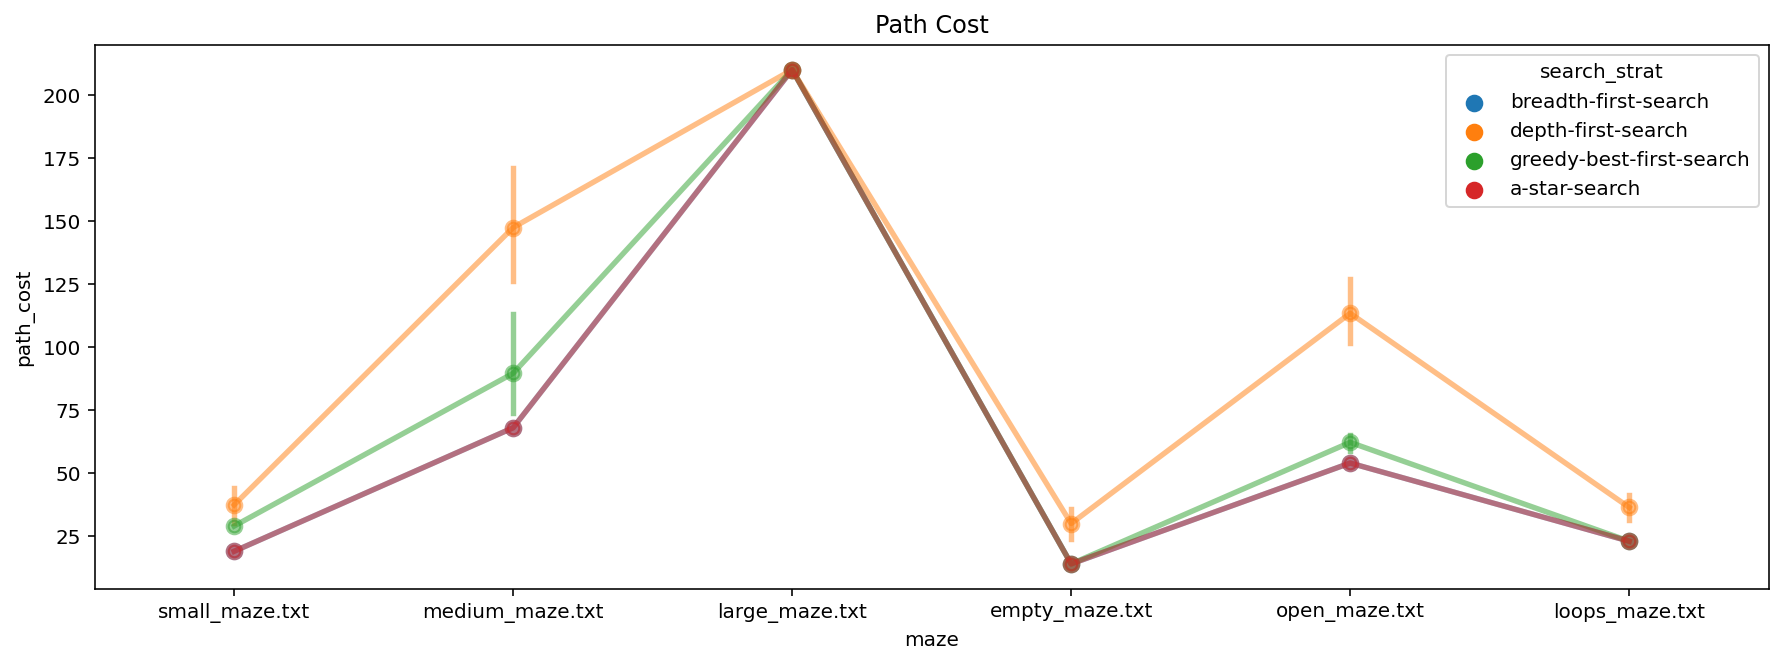

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.title.set_text('Path Cost')
g=sns.pointplot(x="maze",
              y="path_cost",
              data= df,
              hue="search_strat",
              plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #for the markers
plt.setp(g.lines, alpha=.5)       #for the lines

fig.show()

### Nodes Expanded Performance
The first thing to take away from this graph is the high variance of the DFS, and how much worse it performs in the mazes with few walls. You can see specfically in the open_maze it was many orders of magnitutde worse than the other solutions because it had to run multiple times before it didn't get stuck in a corner. The reason DFS performs poorly in the open mazes is because the *branching factor* is higher, that is at any given state there are on average 3 childern states. Where as in the mazes with tight walls there is only usually 1 and sometimes 2 and hardly ever 3.

Another interesting point is the large_maze. This maze has tight walls all the way around. And in terms of nodes expanded DFS does better on average than all the other algorithms. 

C:\Users\Nick\.conda\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


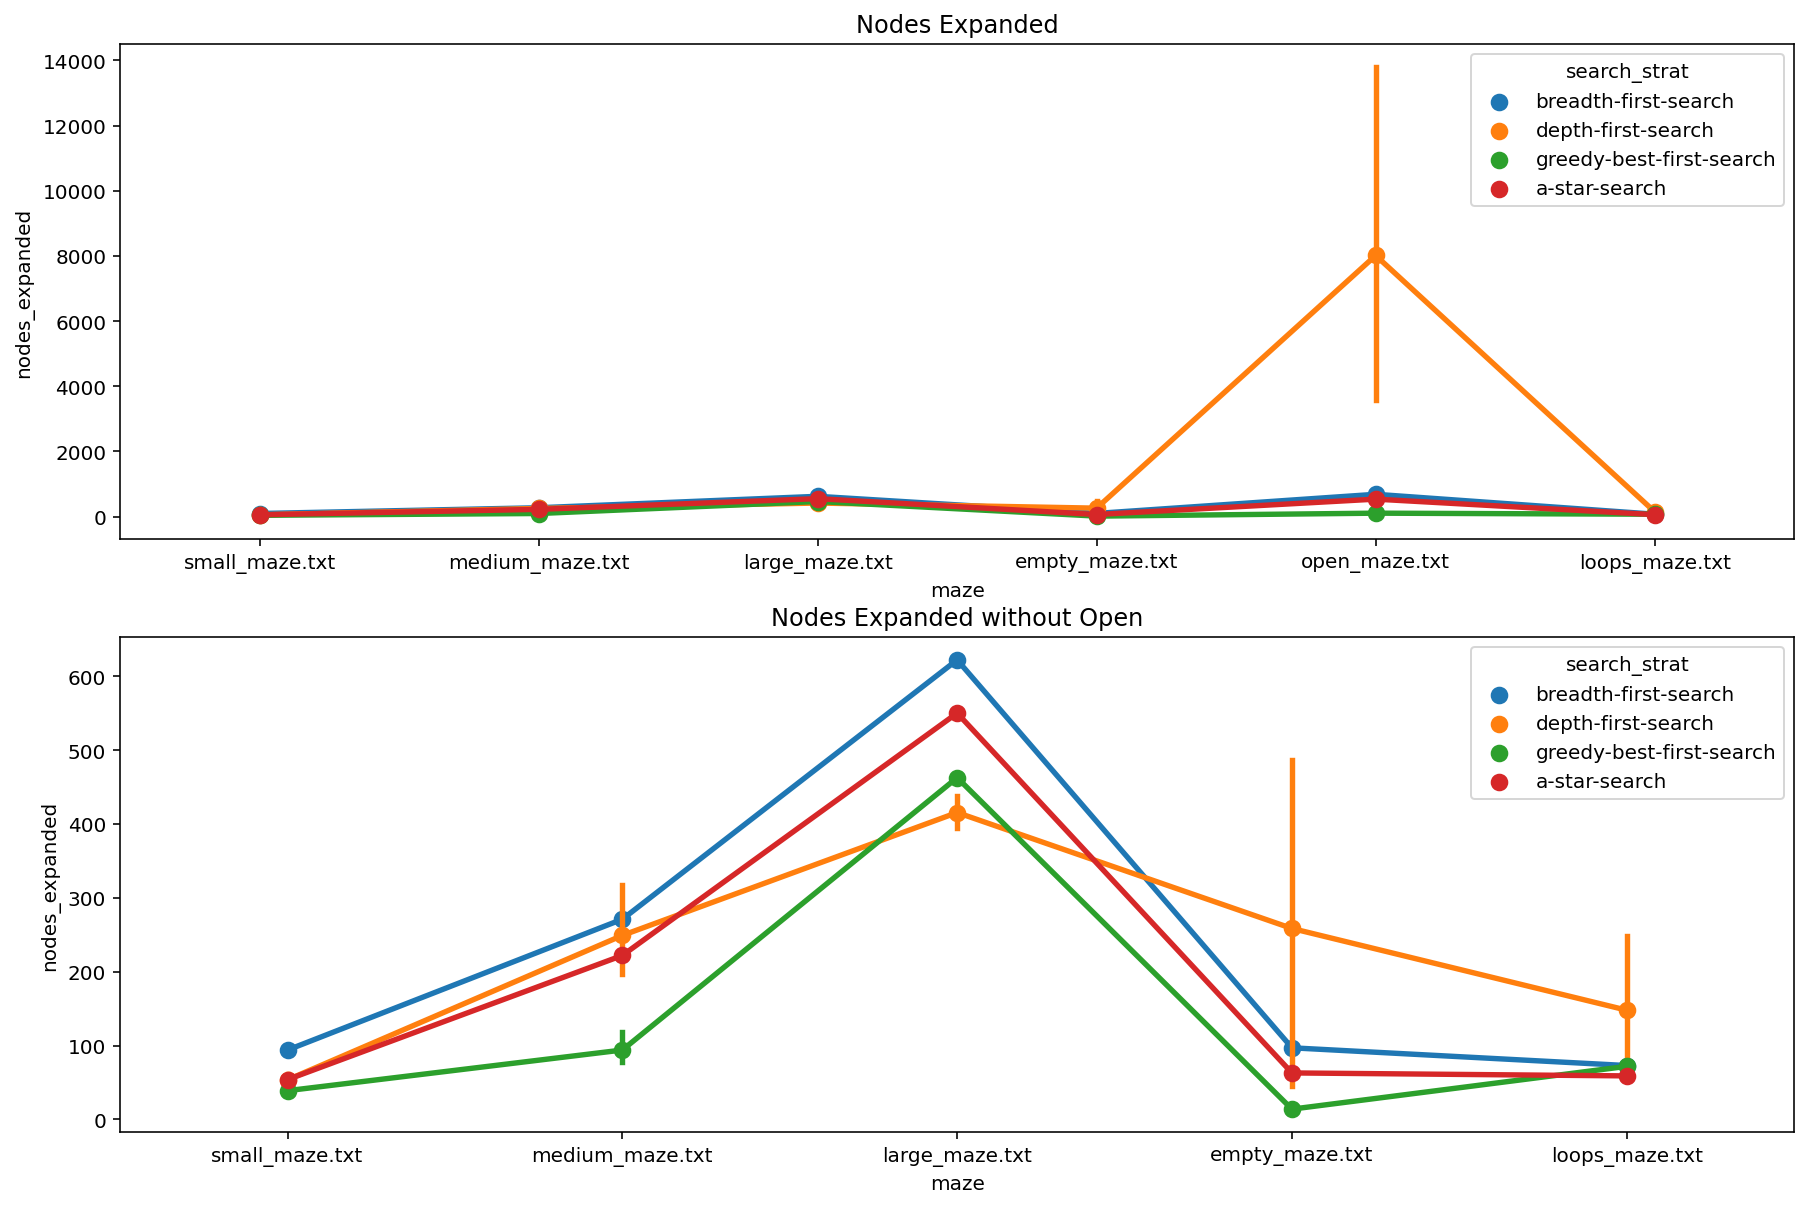

In [18]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
 
ax[0].title.set_text('Nodes Expanded')
sns.pointplot(x="maze",
              y="nodes_expanded",
              data= df,
              hue="search_strat",
              ax=ax[0])

ax[1].title.set_text('Nodes Expanded without Open')
sns.pointplot(x="maze",
              y="nodes_expanded",
              data= df[df.maze != "open_maze.txt"],
              hue="search_strat",
              ax=ax[1])
fig.show()

### Max Tree Depth and Size

C:\Users\Nick\.conda\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


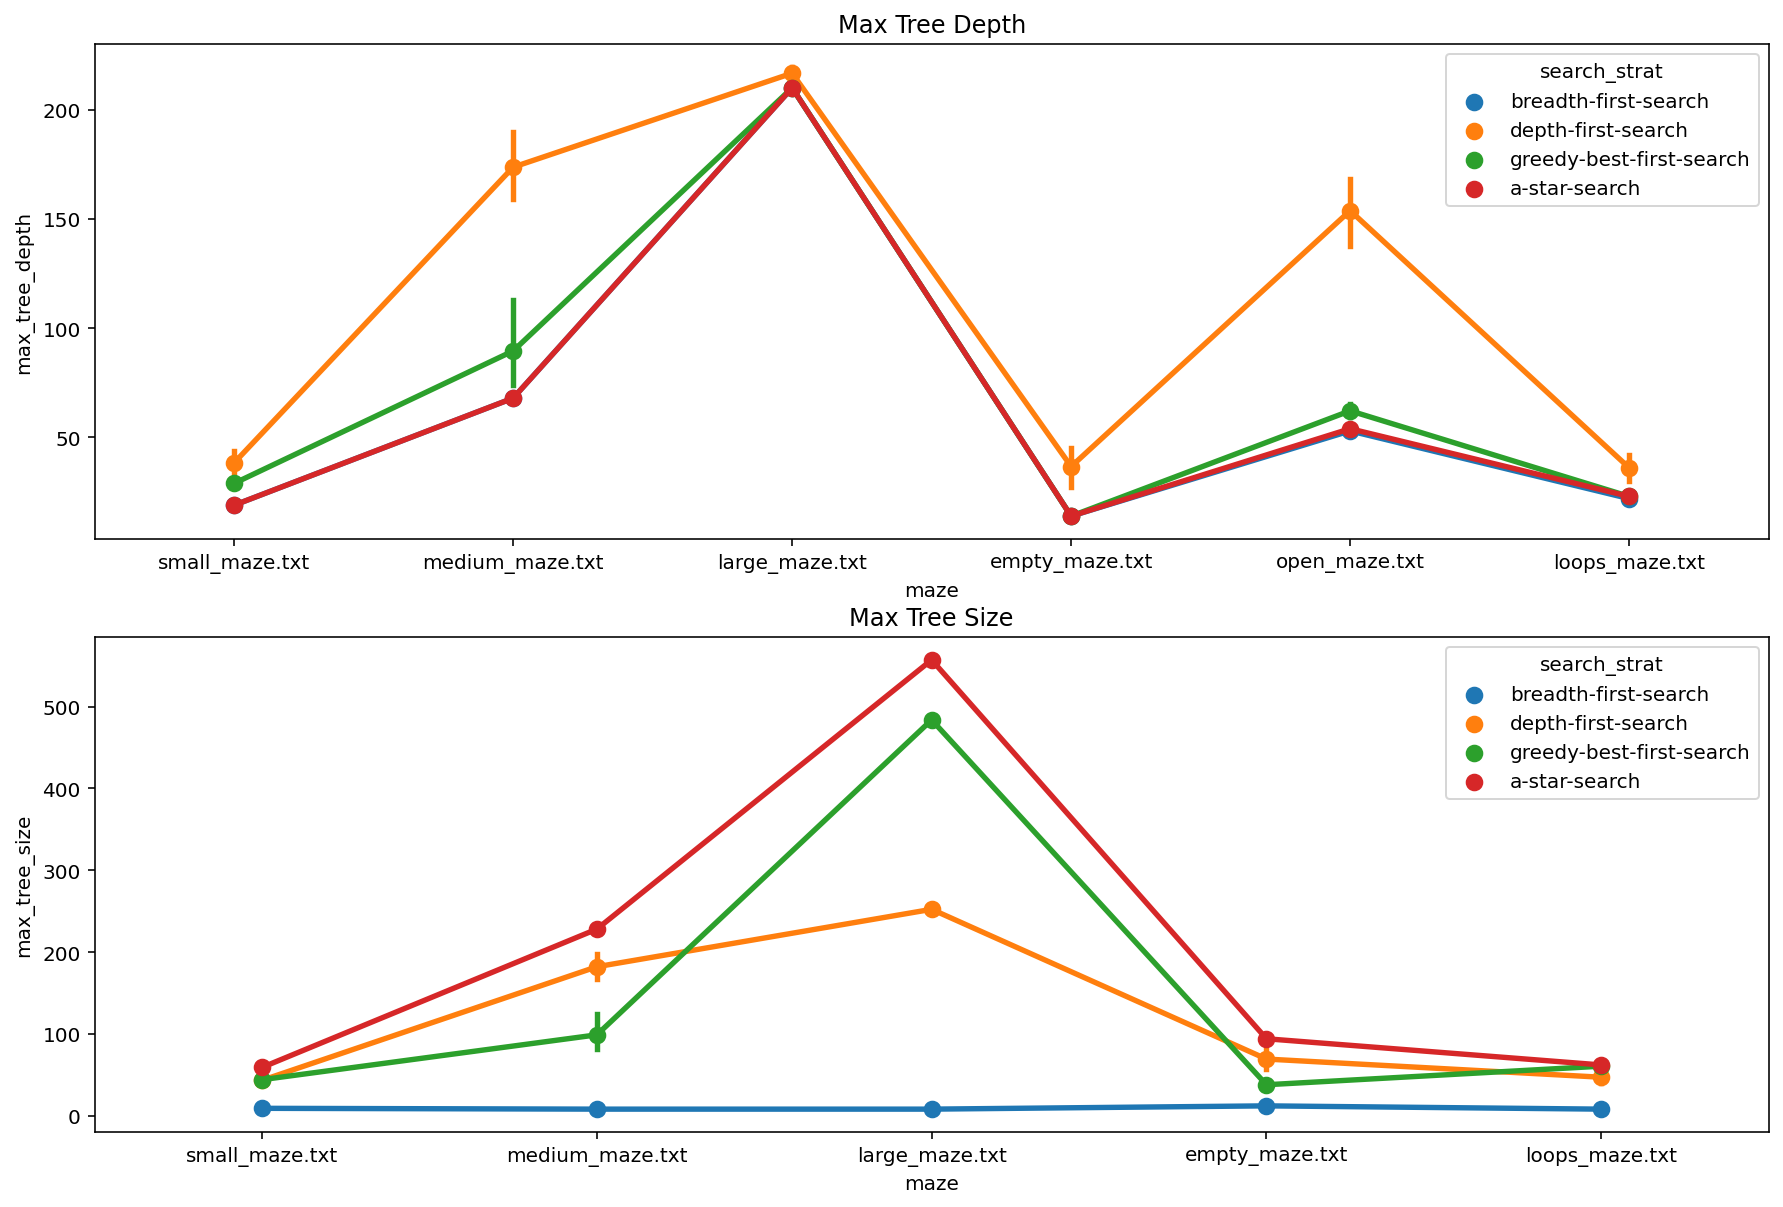

In [19]:
fig, ax = plt.subplots(2,1,figsize=(15,10))

ax[0].title.set_text('Max Tree Depth')
sns.pointplot(x="maze",
              y="max_tree_depth",
              data= df,
              hue="search_strat",
              ax=ax[0])

ax[1].title.set_text('Max Tree Size')
sns.pointplot(x="maze",
              y="max_tree_size",
              data= df[df.maze != "open_maze.txt"],
              hue="search_strat",
              ax=ax[1])
fig.show()

### Max Frontier Size

C:\Users\Nick\.conda\envs\mlenv2020\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


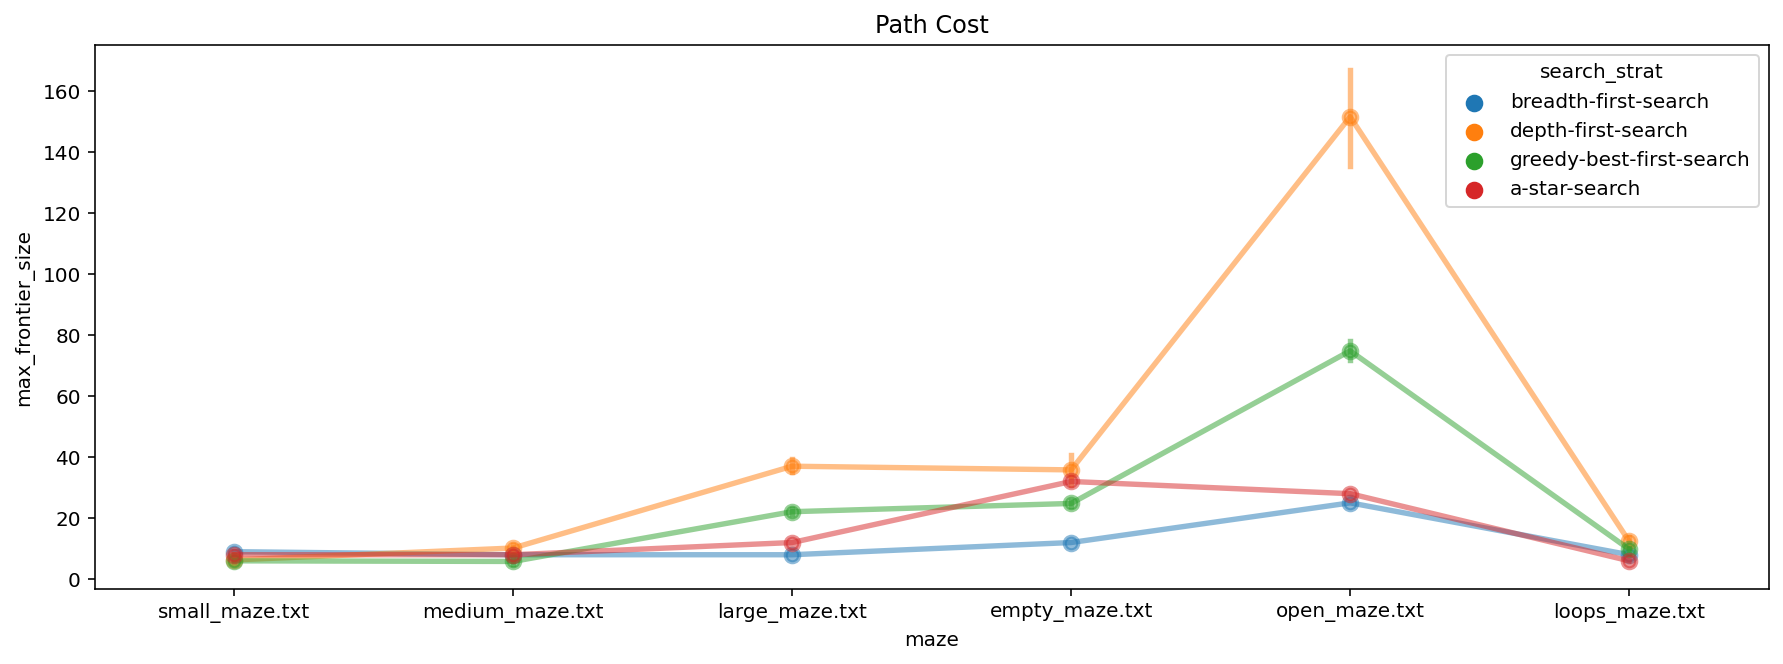

In [20]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.title.set_text('Path Cost')
g=sns.pointplot(x="maze",
              y="max_frontier_size",
              data= df,
              hue="search_strat",
              plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #for the markers
plt.setp(g.lines, alpha=.5)       #for the lines

fig.show()

##### Graduate student advanced task: Multiple Goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding a one or two more goals to the medium sizes maze.
Solve the maze with your implementations for DFS, BFS, and implement IDS (iterative deepening search using DFS). Run experiments to show which implementations find the optimal solution.

### IDS
Here is a simpler implementation of DFS and IDS using from the book. It does not keep stats since the only goal is to see if it finds the best path.

We are going to skip the open_maze because the amount of paths that have to be *walked* with each iteration of IDS gets too large to fast. 

In [21]:
# Your code/answer goes here

def depth_helper(node, depth):
    if node is None:
        return depth
    return depth_helper(node.parent, depth+1)

def depth(node):
    return depth_helper(node, 0)

def depth_limited_search(maze, node, max_depth, verbose_text=False, verbose_graph=False):
    frontier = []
    frontier.append(node)
    
    path_count = 0
    while len(frontier) > 0:
        curr_node = frontier.pop()
        if verbose_graph:
            get_path(curr_node, maze, dot='P')
            print('showing graph')
            show_maze(maze)
        
        if look(maze, curr_node.pos) == 'G':
            return (curr_node, True, path_count)
        if verbose_text:
            print(depth(curr_node))
        if depth(curr_node) > max_depth:
            if verbose_graph:
                get_path(curr_node, maze, dot='.')
            path_count+=1
            continue
        
        child_found = False
        if not is_cycle(node):
            for child in expand_random(curr_node, maze):
                if not is_cycle(child):
                    child_found = True
                    if verbose_graph:
                        set_to_dot(maze, child.pos, dot = 'F')
                    frontier.append(child)
        if not child_found:
            path_count+=1
        
        if verbose_graph:
            show_maze(maze)
            get_path(curr_node, maze, dot='.')
    return (curr_node, False, path_count)

def IDS(maze, node, verbose_text=False, verbose_graph = False):
    for depth in range(1, 10000):
        path_node, success, path_count = depth_limited_search(maze, node, depth, verbose_graph=verbose_graph)
        
        if verbose_graph:
            show_maze(maze)
        if success:
            return path_node
        elif verbose_text:
            print('No goal found at depth:', depth, 'Unique Paths Found: ', path_count)
        reset_maze_clear_tree(path_node, maze)
            

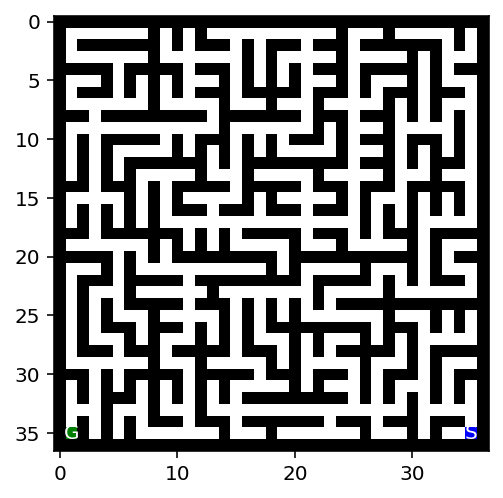

Wall time: 2.53 s


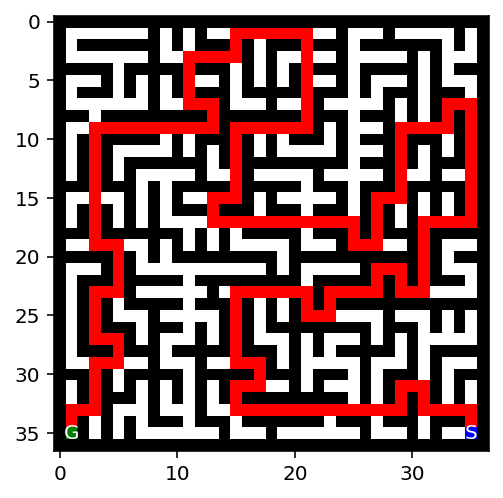

In [22]:
# Run fit on some mazes to test
mazes = [
        #"small_maze.txt",
        #"medium_maze.txt",
        "large_maze.txt",
        #"empty_maze.txt",
        #"open_maze.txt",
        #"loops_maze.txt"
        ]

for m in mazes:
    f = open(m, "r")
    maze_str = f.read()

    maze = parse_maze(maze_str)
    show_maze(maze)

    find_pos(maze, what= 'S')
    #print("Start location:", find_pos(maze, what = "S"))
    initial_node = Node(find_pos(maze, what= 'S'), None, None, 0)
    %time output = IDS(maze, initial_node, verbose_text=False, verbose_graph=False)
    #get_path(maze, output)
    node = output
    get_path(output, maze)
    show_maze(maze)

### Medium mazes with multiple goals

medium_maze.txt


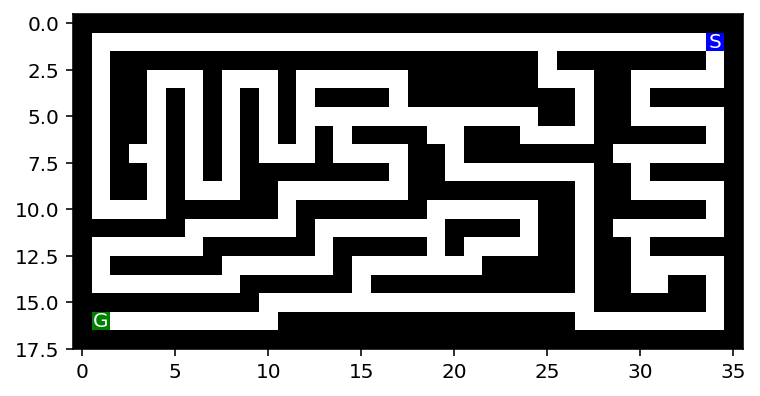

BFS
Wall time: 3 ms


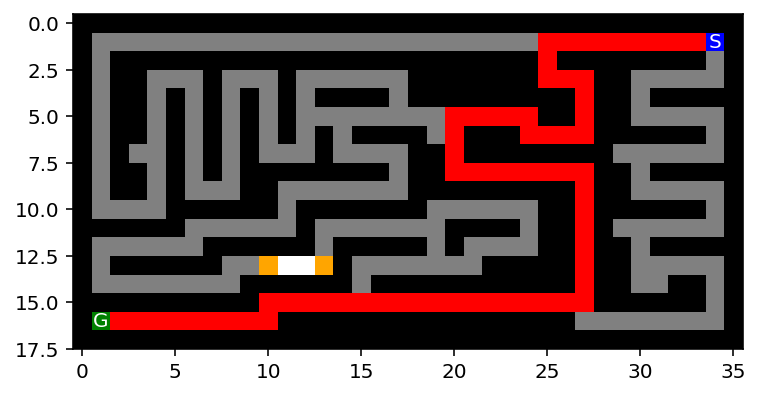

IDS
Wall time: 416 ms


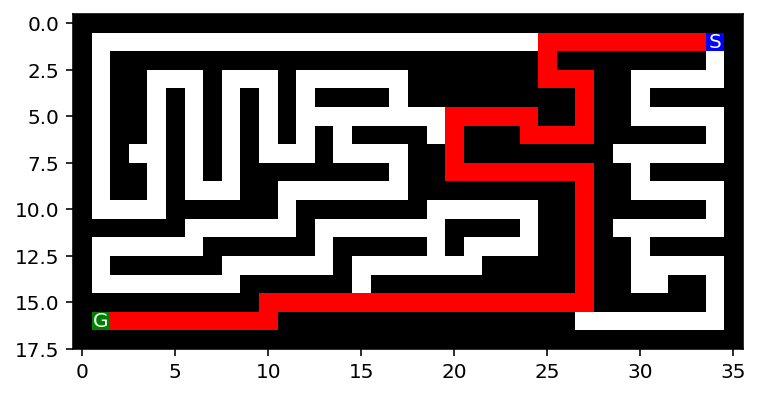

DFS
Wall time: 171 ms


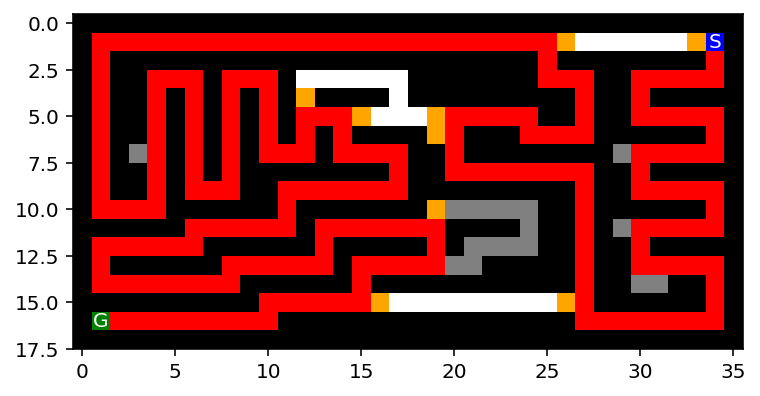

medium_maze_two_goals.txt


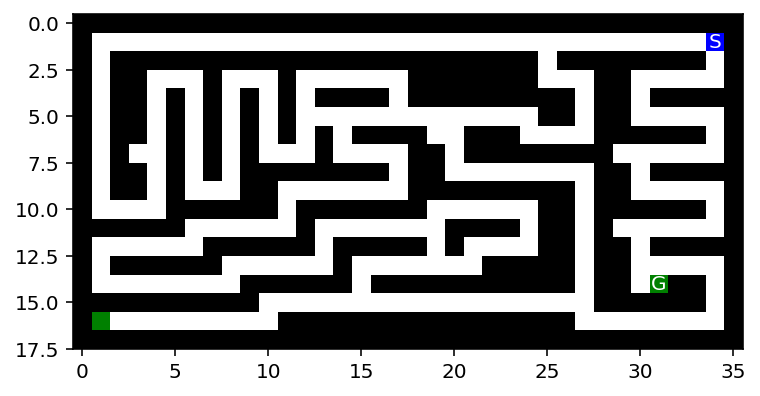

BFS
Wall time: 1e+03 µs


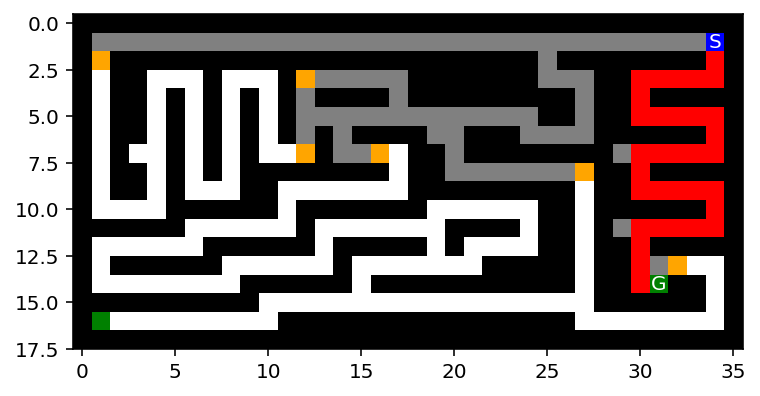

IDS
Wall time: 42.5 ms


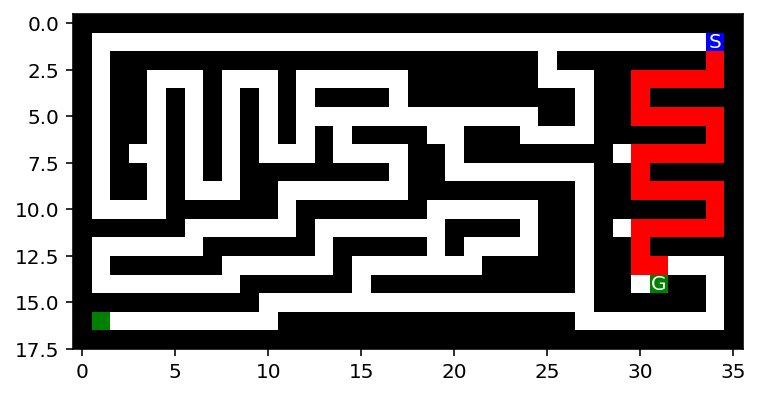

DFS
Wall time: 69.1 ms


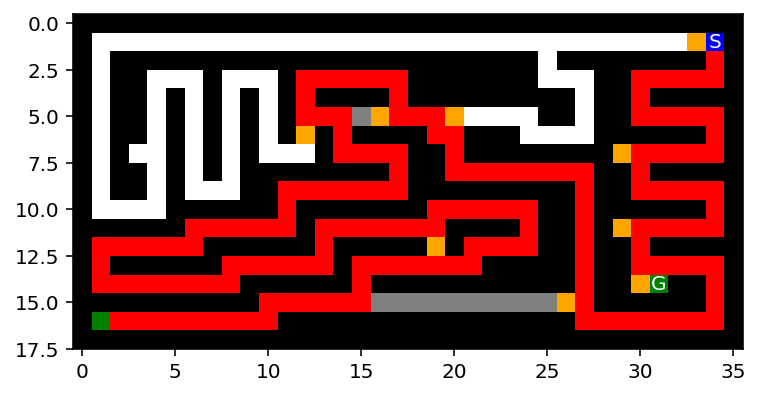

medium_maze_three_goals.txt


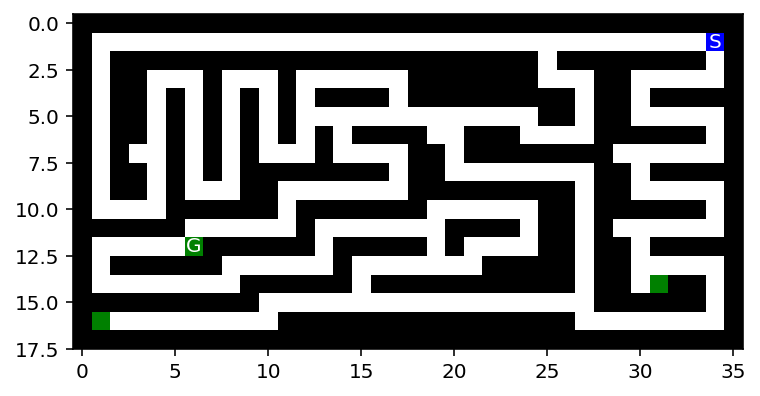

BFS
Wall time: 2 ms


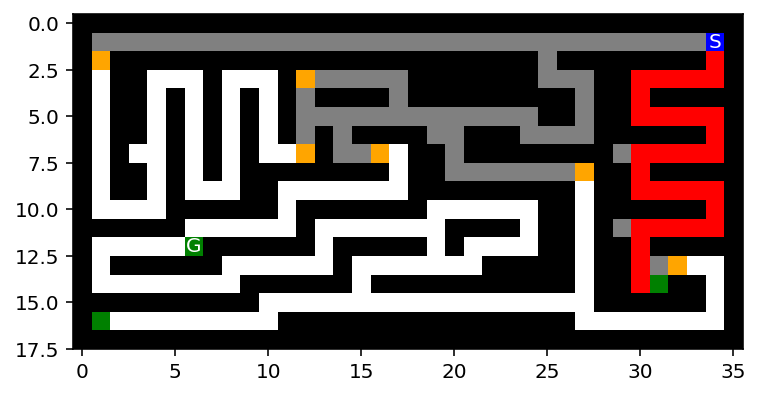

IDS
Wall time: 43 ms


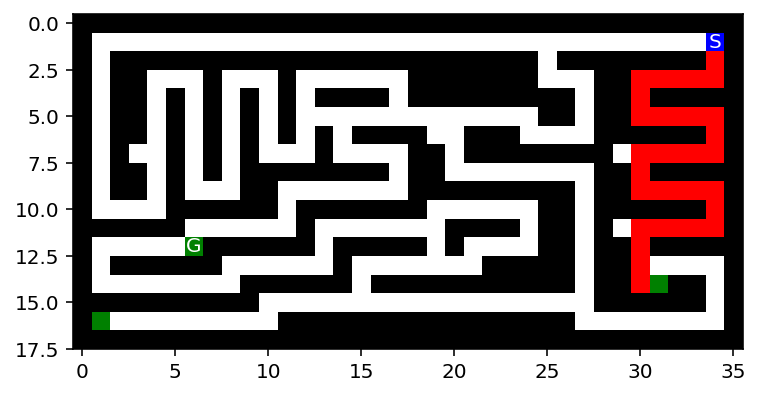

DFS
Wall time: 25 ms


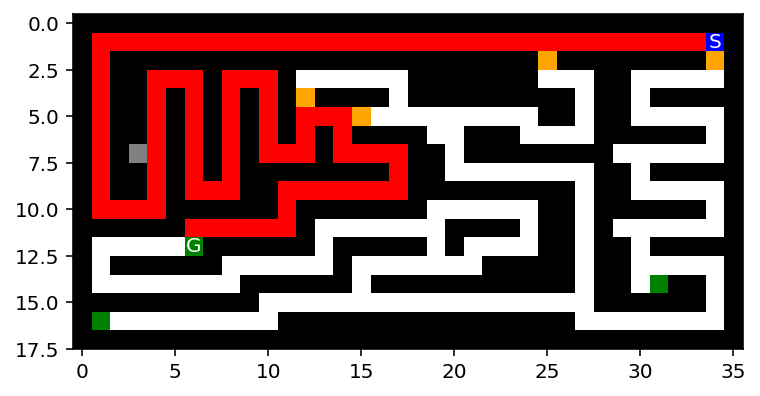

medium_maze_four_goals.txt


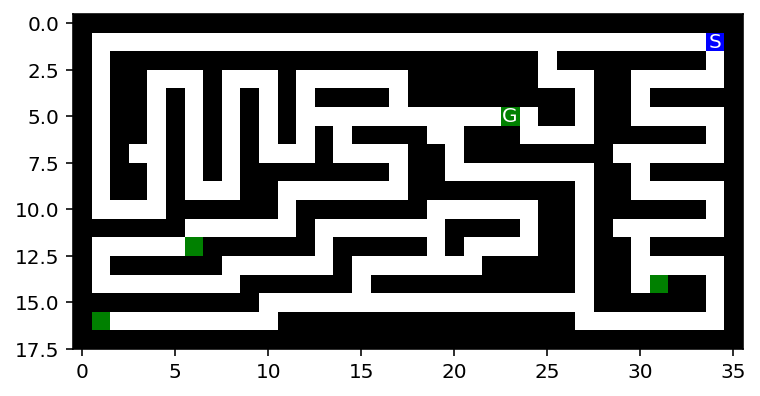

BFS
Wall time: 992 µs


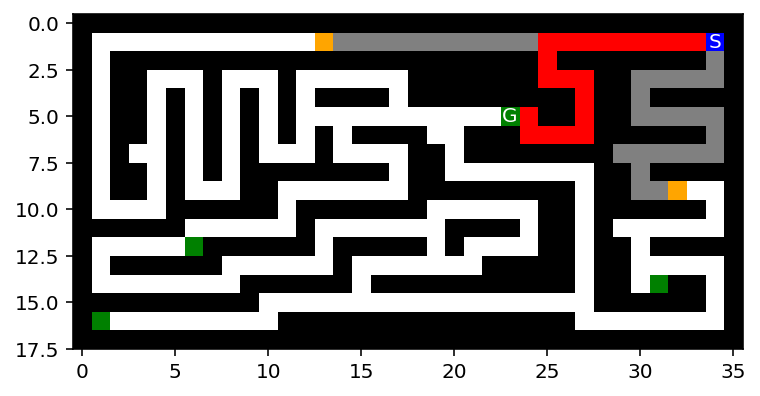

IDS
Wall time: 17 ms


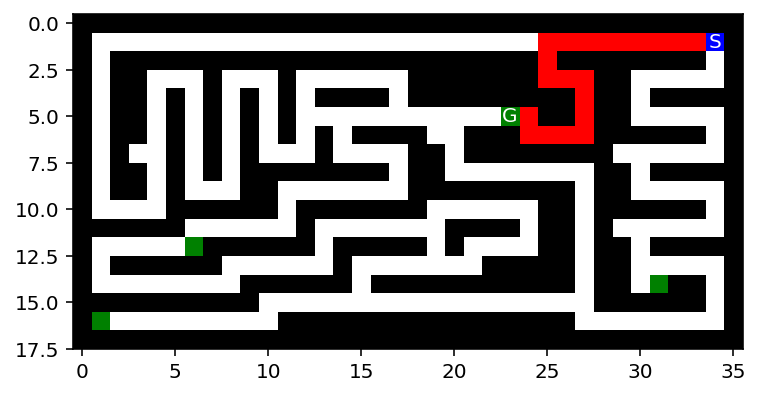

DFS
Wall time: 72.2 ms


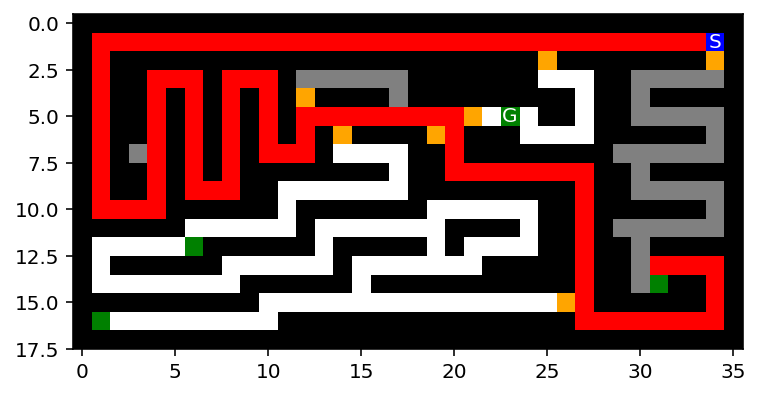

In [23]:
mazes = [
        "medium_maze.txt",
        "medium_maze_two_goals.txt",
        "medium_maze_three_goals.txt",
        "medium_maze_four_goals.txt",
        ]
for m in mazes:
    f = open(m, "r")
    maze_str = f.read()

    maze = parse_maze(maze_str)
    print(m)
    show_maze(maze)
    
    find_pos(maze, what= 'S')
    initial_node = Node(find_pos(maze, what= 'S'), None, None, 0)
    print('BFS')
    %time output = breadth_first_search(maze, initial_node)
    node = output[0]
    get_path(node, maze)
    show_maze(maze)
    reset_maze(maze)
    print('IDS')
    %time output = IDS(maze, initial_node, verbose_text=False, verbose_graph=False)
    node = output
    get_path(output, maze)
    show_maze(maze)
    reset_maze(maze)
    print('DFS')
    %time output = depth_first_search(maze, initial_node, verbose_text=False, verbose_graph=False)
    node = output
    get_path(output[0], maze)
    show_maze(maze)
    

### Optimal Observations

Fist we already discussed that BFS is optimal so it is not surprosing that it will find the closest goal every time. It is easy to find a couple cases in these tests where DFS does not find the closest goal, as it is not a optimal solution. However, IDS is an optimal solution beacuase it will travel every path that exsits at each depth before looking at a deeper path, so the first path it finds that yeilds a goal state will be the shortest path to a goal state

### Runtime

| Goals | Solution | Runtime(ms) |
| --- | --- | --- |
| 1 | BFS | 3 |
| 1 | IDS | 416 |
| 1 | DFS | 171 |
| 2 | BFS | 0.001 |
| 2 | IDS | 42.5 |
| 2 | DFS | 69.1 |
| 3 | BFS | 2 |
| 3 | IDS | 43 |
| 3 | DFS | 25 |
| 4 | BFS | 1 |
| 4 | IDS | 17 |
| 4 | DFS | 72 |

From the table we can see that in terms of runtime BFS is always winning. However, when there are more goal states the IDS performs reliably well because it finds the goal that is close to the start very quickly. DFS still has the randomness problem and may make decisions to go away from all the goals.

## More advanced tasks to think about

**Instead of defining each square as a state (which you probably did), use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length in number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.**

First you would not always add cost of 1, you would add the cost in the amount of steps that it took to get to the space you ended up at. Then in BFS cases once you have a goal state, you will have to continue searching until all other paths exceed that goal states coast. In IDS you will have to iterate depths until the ending path of all nodes is bigger than the the goal state found. Of course if you don't care about optimality, you can just return the path that was the first goal state.

**Modify your A* search to add weights (see text book) and explore how different weights influence the result.**

Unfortunetly I did not have time to complete this, however the code would just step down hallways until there is at least 3 nearby squares without walls

**What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?**

If the agent has a way of knowing where the goal is, you can do something similar to a A* or greedy best first search, but your cost for picking the wrong path will have double the cost of walking the right path cause you have to walk back as well.